In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load Data
data = pd.read_csv('cimb_stock.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Price']]

In [38]:
# Scaling Data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Price'] = scaler.fit_transform(data[['Price']])

# Creating Sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(data['Price'].values, seq_length)

In [39]:
# Splitting Data (Train, Validation, Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [40]:
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),  # Extra Dense layer
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
# Training Model with Validation Set
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# Making Predictions
y_pred_lstm = lstm_model.predict(X_test)

# Inverse Transform Predictions to Original Scale
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Hybrid Model (Weighted Average of LSTM and Linear Regression)
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

y_pred_lr = lr_model.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_lr = scaler.inverse_transform(y_pred_lr.reshape(-1, 1))

# Hybrid Model (70% LSTM, 30% Linear Regression)
y_pred_hybrid = (0.4 * y_pred_lstm) + (0.6 * y_pred_lr)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.0936 - val_loss: 0.0083
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - 

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


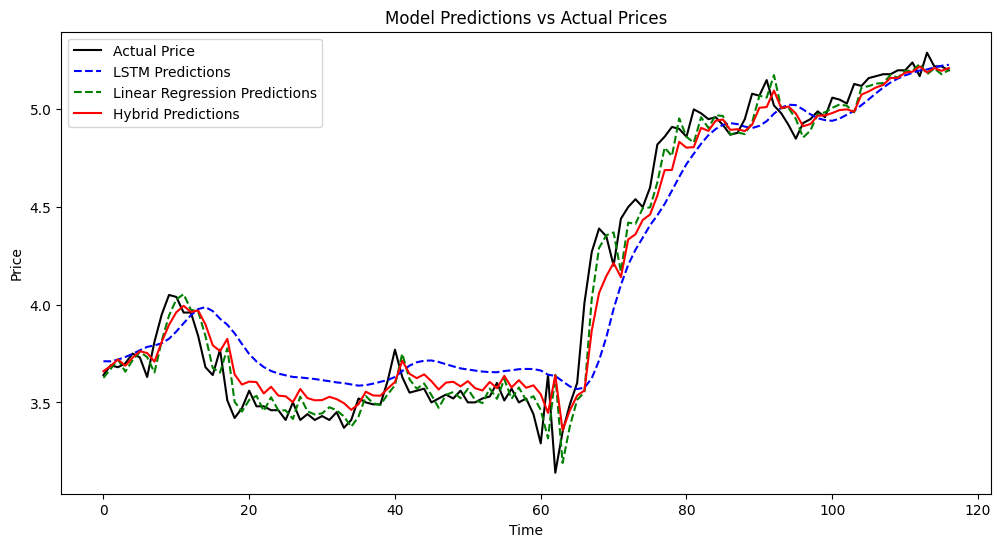

In [42]:
# Plot Results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, color="black", label="Actual Price")
plt.plot(y_pred_lstm, color="blue", linestyle="dashed", label="LSTM Predictions")
plt.plot(y_pred_lr, color="green", linestyle="dashed", label="Linear Regression Predictions")
plt.plot(y_pred_hybrid, color="red", label="Hybrid Predictions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.title("Model Predictions vs Actual Prices")
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate MSE
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)

# Calculate MAE
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)

# Calculate R² Score
r2_lstm = r2_score(y_test, y_pred_lstm)
r2_lr = r2_score(y_test, y_pred_lr)
r2_hybrid = r2_score(y_test, y_pred_hybrid)

# Print Results
print("Model Performance Metrics:\n")
print(f"LSTM Model -> MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}, R² Score: {r2_lstm:.4f}")
print(f"Linear Regression -> MSE: {mse_lr:.4f}, MAE: {mae_lr:.4f}, R² Score: {r2_lr:.4f}")
print(f"Hybrid Model -> MSE: {mse_hybrid:.4f}, MAE: {mae_hybrid:.4f}, R² Score: {r2_hybrid:.4f}")


Model Performance Metrics:

LSTM Model -> MSE: 0.0414, MAE: 0.1577, R² Score: 0.9164
Linear Regression -> MSE: 0.0125, MAE: 0.0753, R² Score: 0.9749
Hybrid Model -> MSE: 0.0174, MAE: 0.0958, R² Score: 0.9650


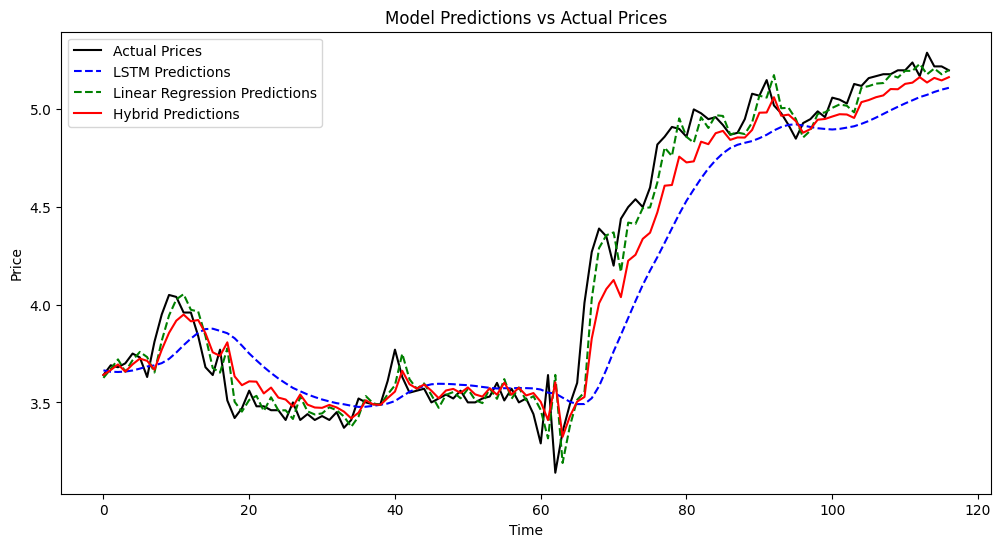

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color="black")
plt.plot(y_pred_lstm, label="LSTM Predictions", linestyle="dashed", color="blue")
plt.plot(y_pred_lr, label="Linear Regression Predictions", linestyle="dashed", color="green")
plt.plot(y_pred_hybrid, label="Hybrid Predictions", color="red")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Model Predictions vs Actual Prices")
plt.show()
